In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from collections import Counter
from scipy.stats import shapiro
from scipy.stats import wilcoxon


In [4]:
import pandas as pd

# Leitura dos dados, ignorando linhas com problemas de tokenização e corrigindo tipos mistos
df_netflix = pd.read_csv('sample_data/netflix_titles.csv', on_bad_lines='skip')
df_rt = pd.read_csv('sample_data/rotten_tomatoes_movies.csv', on_bad_lines='skip')
imdb_ratings = pd.read_csv('sample_data/title.ratings.tsv', sep='\t', on_bad_lines='skip')
imdb_basics = pd.read_csv('sample_data/title.basics.tsv', sep='\t', on_bad_lines='skip', low_memory=False)

# Preparação dos dados do IMDb - Filtrar apenas filmes e selecionar colunas relevantes
imdb_basics_films = imdb_basics[imdb_basics['titleType'] == 'movie'][['tconst', 'primaryTitle', 'startYear', 'genres']]
imdb_basics_films['primaryTitle'] = imdb_basics_films['primaryTitle'].str.lower()  # Títulos em minúsculas para correspondência
imdb_basics_films['startYear'] = pd.to_numeric(imdb_basics_films['startYear'], errors='coerce')  # Converter o ano para numérico

# Merge IMDb - Combinar dados básicos com classificações
imdb_combined = pd.merge(imdb_basics_films, imdb_ratings, on='tconst', how='inner')

# Preparação dos dados do Rotten Tomatoes - Converter para minúsculas para correspondência e extrair ano de 'original_release_date'
df_rt['movie_title_lower'] = df_rt['movie_title'].str.lower()
df_rt['original_release_date'] = pd.to_datetime(df_rt['original_release_date'], errors='coerce')
df_rt['year'] = df_rt['original_release_date'].dt.year

# Preparação dos dados da Netflix - Converter títulos para minúsculas e ajustar ano
df_netflix['title_lower'] = df_netflix['title'].str.lower()
df_netflix['release_year'] = pd.to_numeric(df_netflix['release_year'], errors='coerce')

# Filtrar apenas filmes de terror de cada fonte
df_netflix_horror = df_netflix[df_netflix['listed_in'].str.contains('Horror', case=False, na=False)].copy()
df_rt_horror = df_rt[df_rt['genres'].str.contains('Horror', case=False, na=False)].copy()
imdb_horror = imdb_combined[imdb_combined['genres'].str.contains('Horror', case=False, na=False)].copy()

# Merge dos dados de Netflix e Rotten Tomatoes
netflix_rt_merged = pd.merge(df_netflix_horror, df_rt_horror, left_on=['title_lower', 'release_year'],
                             right_on=['movie_title_lower', 'year'], how='inner', suffixes=('_netflix', '_rt'))

# Remover duplicatas após o primeiro merge
netflix_rt_merged = netflix_rt_merged.drop_duplicates(subset=['title_lower', 'release_year'])

# Merge com os dados do IMDb
horror_df = pd.merge(netflix_rt_merged, imdb_horror, left_on=['title_lower', 'release_year'],
                     right_on=['primaryTitle', 'startYear'], how='inner', suffixes=('', '_imdb'))

# Remover duplicatas no merge final
horror_df = horror_df.drop_duplicates(subset=['title_lower', 'release_year'])

# Criar o DataFrame de Ratings Combinados
ratings_df = horror_df[['title_lower', 'release_year', 'rating', 'tomatometer_rating', 'audience_rating', 'averageRating', 'numVotes']].copy()

# Renomear colunas para maior clareza
ratings_df = ratings_df.rename(columns={
    'rating': 'Netflix_Rating',
    'tomatometer_rating': 'RottenTomatoes_Critic_Rating',
    'audience_rating': 'RottenTomatoes_Audience_Rating',
    'averageRating': 'IMDb_Rating',
    'numVotes': 'IMDb_NumVotes'
})

print("Combined Ratings DataFrame:")
print(ratings_df.head())  # Exibir algumas linhas do DataFrame de Ratings combinados


Combined Ratings DataFrame:
                                        title_lower  release_year  \
0                                        dark skies          2013   
1                                            jaws 2          1978   
2                                 jaws: the revenge          1987   
3  the haunting in connecticut 2: ghosts of georgia          2013   
4                                     the strangers          2008   

  Netflix_Rating  RottenTomatoes_Critic_Rating  \
0          PG-13                          41.0   
1             PG                          58.0   
2          PG-13                           0.0   
3              R                          19.0   
4              R                          48.0   

   RottenTomatoes_Audience_Rating  IMDb_Rating  IMDb_NumVotes  
0                            49.0          6.3          80817  
1                            38.0          5.8          86147  
2                            15.0          3.0          50481  


Colunas disponíveis no horror_df: Index(['show_id', 'type', 'title', 'director', 'cast', 'country', 'date_added',
       'release_year', 'rating', 'duration', 'listed_in', 'description',
       'title_lower', 'rotten_tomatoes_link', 'movie_title', 'movie_info',
       'critics_consensus', 'content_rating', 'genres', 'directors', 'authors',
       'actors', 'original_release_date', 'streaming_release_date', 'runtime',
       'production_company', 'tomatometer_status', 'tomatometer_rating',
       'tomatometer_count', 'audience_status', 'audience_rating',
       'audience_count', 'tomatometer_top_critics_count',
       'tomatometer_fresh_critics_count', 'tomatometer_rotten_critics_count',
       'movie_title_lower', 'year', 'tconst', 'primaryTitle', 'startYear',
       'genres_imdb', 'averageRating', 'numVotes'],
      dtype='object')
Exemplo de dados em 'all_genres': 0                        [Horror,  Mystery & Suspense]
1    [Action & Adventure,  Horror,  Mystery & Suspe...
2    [Actio

c:\AppData\Local\Temp\ipykernel_17336\3625536122.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Genre', data=genre_df, palette='viridis')


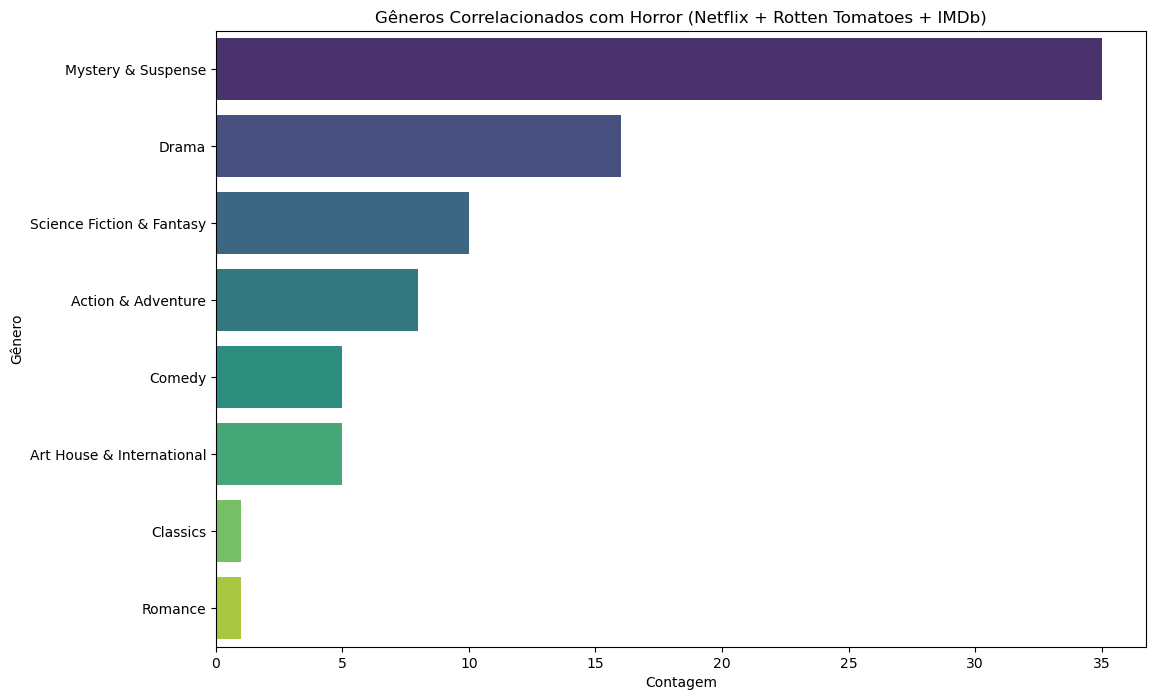

In [6]:
# Verificar as colunas presentes no DataFrame horror_df
print("Colunas disponíveis no horror_df:", horror_df.columns)

# Combinar gêneros de diferentes fontes se as colunas existirem
if 'genres_netflix' in horror_df.columns and 'genres_rotten' in horror_df.columns:
    # Combine gêneros de diferentes fontes
    horror_df['all_genres'] = horror_df['genres_netflix'] + horror_df['genres_rotten']
elif 'genres' in horror_df.columns:
    # Se apenas a coluna 'genres' estiver presente
    horror_df['all_genres'] = horror_df['genres'].str.split(',')
else:
    print("Nenhuma coluna de gêneros disponível para combinar. Verifique os dados.")

# Verifique se a coluna 'all_genres' foi criada corretamente
print("Exemplo de dados em 'all_genres':", horror_df['all_genres'].head())

# Contar a frequência de cada gênero associado com "Horror"
if 'all_genres' in horror_df.columns:
    horror_df.loc[:, 'genres_without_horror'] = horror_df['all_genres'].apply(lambda x: [genre.strip() for genre in x if 'Horror' not in genre])

    # Contagem dos gêneros correlacionados com Horror
    all_genres = [genre for sublist in horror_df['genres_without_horror'] for genre in sublist]
    genre_counts = Counter(all_genres)

    # Converter o contador em DataFrame para visualização
    genre_df = pd.DataFrame(genre_counts.items(), columns=['Genre', 'Count'])

    # Excluir todos os gêneros que contenham "Horror" do DataFrame para visualização
    genre_df = genre_df[~genre_df['Genre'].str.contains('Horror', case=False, na=False)]

    # Ordenar o DataFrame por contagem
    genre_df = genre_df.sort_values(by='Count', ascending=False)

    # Visualizar os gêneros correlacionados com horror
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Count', y='Genre', data=genre_df, palette='viridis')
    plt.title('Gêneros Correlacionados com Horror (Netflix + Rotten Tomatoes + IMDb)')
    plt.xlabel('Contagem')
    plt.ylabel('Gênero')
    plt.show()
else:
    print("Não foi possível criar a coluna 'all_genres'. Verifique os dados.")

In [7]:
import pandas as pd

# Certificar-se de que a coluna 'RottenTomatoes_Critic_Rating' está no formato numérico
ratings_df.loc[:, 'RottenTomatoes_Critic_Rating'] = pd.to_numeric(ratings_df['RottenTomatoes_Critic_Rating'], errors='coerce')

# Remover linhas com avaliações ausentes
ratings_clean_df = ratings_df.dropna(subset=['RottenTomatoes_Critic_Rating'])

# Ordenar por notas para encontrar os filmes com as notas mais altas e mais baixas
highest_rated = ratings_clean_df.sort_values(by='RottenTomatoes_Critic_Rating', ascending=False).head(10)
lowest_rated = ratings_clean_df.sort_values(by='RottenTomatoes_Critic_Rating', ascending=True).head(10)

print("Filmes de Terror com as Notas Mais Altas (Rotten Tomatoes - Críticos):")
print(highest_rated[['title_lower', 'release_year', 'RottenTomatoes_Critic_Rating']])

print("\nFilmes de Terror com as Notas Mais Baixas (Rotten Tomatoes - Críticos):")
print(lowest_rated[['title_lower', 'release_year', 'RottenTomatoes_Critic_Rating']])


Filmes de Terror com as Notas Mais Altas (Rotten Tomatoes - Críticos):
         title_lower  release_year  RottenTomatoes_Critic_Rating
27           creep 2          2017                         100.0
31  under the shadow          2016                          99.0
57   rosemary's baby          1968                          96.0
72     the evil dead          1981                          95.0
19        sweetheart          2019                          95.0
38            carrie          1976                          93.0
25               cam          2018                          93.0
30       little evil          2017                          92.0
29     gerald's game          2017                          91.0
83        zombieland          2009                          89.0

Filmes de Terror com as Notas Mais Baixas (Rotten Tomatoes - Críticos):
                title_lower  release_year  RottenTomatoes_Critic_Rating
2         jaws: the revenge          1987                           0

In [26]:
# Exibir todos os subgêneros presentes no 'horror_df'
all_subgenres = set([genre.strip() for genres in horror_df['all_genres'] if isinstance(genres, list) for genre in genres])
print("Subgêneros presentes no horror_df:", all_subgenres)

# Definir subgêneros mais amplos ou ajustar os subgêneros a partir dos dados reais
subgenres = ['Thriller', 'Mystery & Suspense', 'Drama', 'Science Fiction & Fantasy', 'Action & Adventure']

# Manter controle dos subgêneros já processados
processed_titles = set()

# Analisar notas dos críticos e da audiência por subgêneros correlacionados
for genre in subgenres:
    # Usar .str.contains() para capturar variações nos nomes dos subgêneros
    subgenre_df = horror_df[horror_df['all_genres'].apply(lambda x: any(pd.Series(x).str.contains(genre, case=False)) if isinstance(x, list) else False)]

    # Verificar se existem dados suficientes para calcular médias
    if subgenre_df.empty:
        print(f"Gênero: {genre} - Nenhum dado disponível.\n")
        continue

    # Obter os títulos únicos dos filmes que pertencem ao subgênero atual
    titles = set(subgenre_df['title_lower'])

    # Evitar repetição de títulos já processados
    titles_to_process = titles - processed_titles

    if not titles_to_process:
        print(f"Gênero: {genre} - Nenhum título único novo para processar.\n")
        continue

    # Atualizar os títulos processados
    processed_titles.update(titles_to_process)

    # Filtrar o DataFrame 'ratings_df' para incluir apenas os filmes pertencentes ao subgênero
    ratings_subgenre_df = ratings_df[ratings_df['title_lower'].isin(titles_to_process)].copy()

    # Verificar se há filmes restantes após o filtro
    if ratings_subgenre_df.empty:
        print(f"Gênero: {genre} - Nenhum dado disponível após o filtro de títulos.\n")
        continue

    # Certificar-se de que as colunas de avaliações estão no formato numérico usando .loc para evitar SettingWithCopyWarning
    ratings_subgenre_df.loc[:, 'RottenTomatoes_Critic_Rating'] = pd.to_numeric(ratings_subgenre_df['RottenTomatoes_Critic_Rating'], errors='coerce')
    ratings_subgenre_df.loc[:, 'RottenTomatoes_Audience_Rating'] = pd.to_numeric(ratings_subgenre_df['RottenTomatoes_Audience_Rating'], errors='coerce')

    # Remover linhas com avaliações ausentes
    ratings_subgenre_df = ratings_subgenre_df.dropna(subset=['RottenTomatoes_Critic_Rating', 'RottenTomatoes_Audience_Rating'])

    # Verificar se há filmes restantes após a remoção de NaNs
    if ratings_subgenre_df.empty:
        print(f"Gênero: {genre} - Nenhum dado disponível após remoção de NaNs.\n")
        continue

    # Calcular a média das notas dos críticos e da audiência
    critics_mean = ratings_subgenre_df['RottenTomatoes_Critic_Rating'].mean()
    audience_mean = ratings_subgenre_df['RottenTomatoes_Audience_Rating'].mean()

    # Exibir os resultados
    print(f"Gênero: {genre}")
    print(f"Nota Média dos Críticos: {critics_mean:.2f}")
    print(f"Nota Média da Audiência: {audience_mean:.2f}\n")


Subgêneros presentes no horror_df: {'Romance', 'Science Fiction & Fantasy', 'Horror', 'Drama', 'Mystery & Suspense', 'Comedy', 'Classics', 'Art House & International', 'Action & Adventure'}
Gênero: Thriller - Nenhum dado disponível.

Gênero: Mystery & Suspense
Nota Média dos Críticos: 50.23
Nota Média da Audiência: 47.86

Gênero: Drama
Nota Média dos Críticos: 50.88
Nota Média da Audiência: 44.50

Gênero: Science Fiction & Fantasy
Nota Média dos Críticos: 51.67
Nota Média da Audiência: 50.17

Gênero: Action & Adventure
Nota Média dos Críticos: 28.00
Nota Média da Audiência: 35.00



Colunas disponíveis no ratings_df: Index(['title_lower', 'release_year', 'Netflix_Rating',
       'RottenTomatoes_Critic_Rating', 'RottenTomatoes_Audience_Rating',
       'IMDb_Rating', 'IMDb_NumVotes'],
      dtype='object')


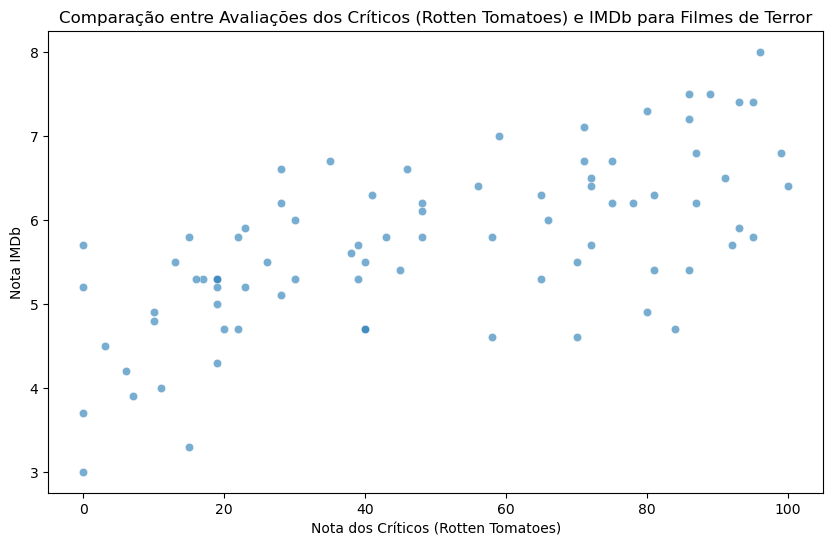

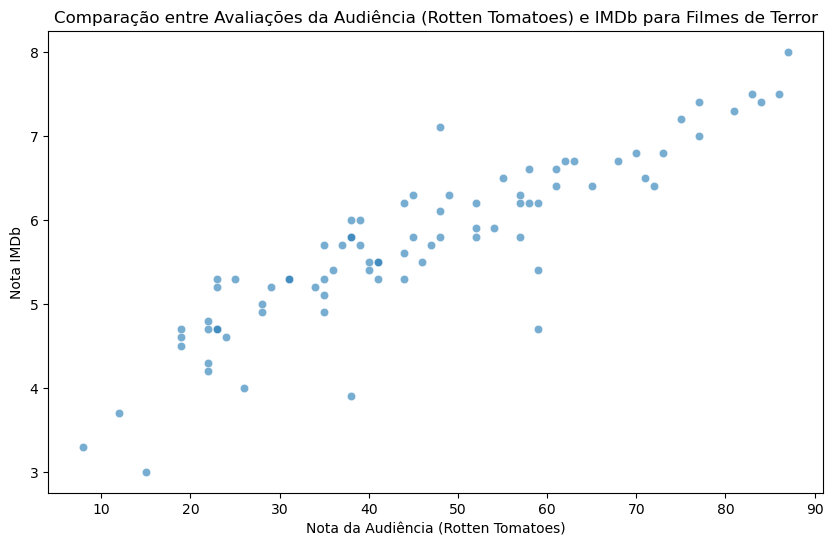

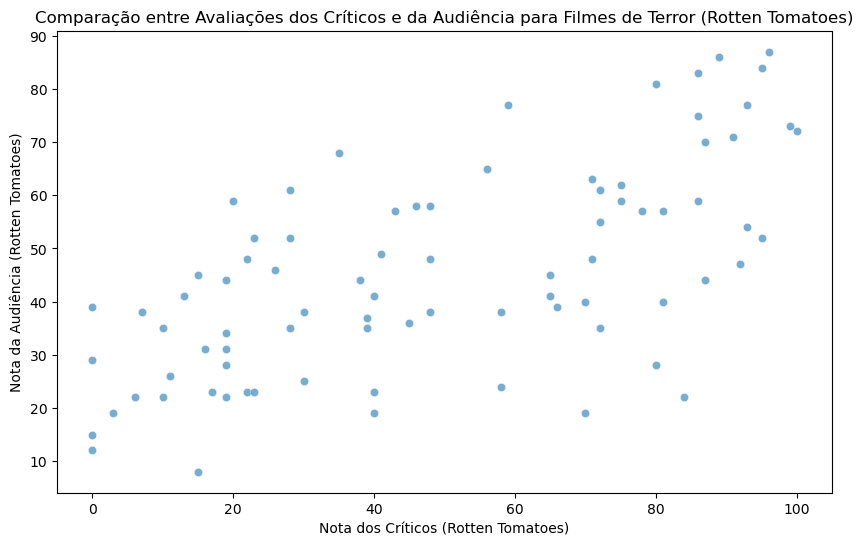

In [50]:
import pandas as pd

# Verificar as colunas disponíveis no 'ratings_df'
print("Colunas disponíveis no ratings_df:", ratings_df.columns)

# Ajustar o nome da coluna com base nas colunas reais presentes no DataFrame
# Verifique se a coluna de avaliação do IMDb está disponível e ajuste o nome se necessário
if 'averageRating' in ratings_df.columns:
    ratings_df['IMDb_Rating'] = pd.to_numeric(ratings_df['averageRating'], errors='coerce')
elif 'IMDb_Rating' in ratings_df.columns:
    ratings_df['IMDb_Rating'] = pd.to_numeric(ratings_df['IMDb_Rating'], errors='coerce')
else:
    print("Coluna de avaliação IMDb não encontrada no ratings_df. Verifique os dados.")
    # Adicione lógica para lidar com a ausência de dados, se necessário

# Prosseguir com o código se a coluna IMDb_Rating estiver disponível
if 'IMDb_Rating' in ratings_df.columns and 'RottenTomatoes_Critic_Rating' in ratings_df.columns and 'RottenTomatoes_Audience_Rating' in ratings_df.columns:
    # Criar um DataFrame de comparação com as notas dos críticos, audiência, e IMDb
    comparison_df = ratings_df[['RottenTomatoes_Critic_Rating', 'RottenTomatoes_Audience_Rating', 'IMDb_Rating']].dropna()

    # Plotar a comparação entre Rotten Tomatoes (críticos) e IMDb
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='RottenTomatoes_Critic_Rating', y='IMDb_Rating', data=comparison_df, alpha=0.6)
    plt.title('Comparação entre Avaliações dos Críticos (Rotten Tomatoes) e IMDb para Filmes de Terror')
    plt.xlabel('Nota dos Críticos (Rotten Tomatoes)')
    plt.ylabel('Nota IMDb')
    plt.show()

    # Plotar a comparação entre Rotten Tomatoes (audiência) e IMDb
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='RottenTomatoes_Audience_Rating', y='IMDb_Rating', data=comparison_df, alpha=0.6)
    plt.title('Comparação entre Avaliações da Audiência (Rotten Tomatoes) e IMDb para Filmes de Terror')
    plt.xlabel('Nota da Audiência (Rotten Tomatoes)')
    plt.ylabel('Nota IMDb')
    plt.show()

    # Plotar a comparação entre Rotten Tomatoes (críticos) e Rotten Tomatoes (audiência)
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='RottenTomatoes_Critic_Rating', y='RottenTomatoes_Audience_Rating', data=comparison_df, alpha=0.6)
    plt.title('Comparação entre Avaliações dos Críticos e da Audiência para Filmes de Terror (Rotten Tomatoes)')
    plt.xlabel('Nota dos Críticos (Rotten Tomatoes)')
    plt.ylabel('Nota da Audiência (Rotten Tomatoes)')
    plt.show()
else:
    print("Dados insuficientes para gerar comparações. Verifique se todas as colunas de avaliação estão presentes no DataFrame.")


In [52]:
from scipy.stats import shapiro
import pandas as pd

# Certifique-se de que estamos usando as colunas corretas para as notas dos críticos e da audiência
if 'RottenTomatoes_Critic_Rating' in comparison_df.columns and 'RottenTomatoes_Audience_Rating' in comparison_df.columns:
    # Teste de Shapiro-Wilk para normalidade
    shapiro_test_critics = shapiro(comparison_df['RottenTomatoes_Critic_Rating'])
    shapiro_test_audience = shapiro(comparison_df['RottenTomatoes_Audience_Rating'])
    
    # Exibir os resultados do teste de normalidade
    print(f"Valor-p para normalidade das notas dos críticos (Rotten Tomatoes): {shapiro_test_critics.pvalue:.5f}")
    print(f"Valor-p para normalidade das notas da audiência (Rotten Tomatoes): {shapiro_test_audience.pvalue:.5f}")

    # Conclusão para notas dos críticos
    if shapiro_test_critics.pvalue < 0.05:
        print("Rejeitamos a hipótese nula. As notas dos críticos não seguem uma distribuição normal.")
    else:
        print("Não podemos rejeitar a hipótese nula. As notas dos críticos seguem uma distribuição normal.")

    # Conclusão para notas da audiência
    if shapiro_test_audience.pvalue < 0.05:
        print("Rejeitamos a hipótese nula. As notas da audiência não seguem uma distribuição normal.")
    else:
        print("Não podemos rejeitar a hipótese nula. As notas da audiência seguem uma distribuição normal.")
else:
    print("As colunas de notas dos críticos e/ou audiência não estão disponíveis no DataFrame 'comparison_df'. Verifique os dados.")


Valor-p para normalidade das notas dos críticos (Rotten Tomatoes): 0.00034
Valor-p para normalidade das notas da audiência (Rotten Tomatoes): 0.08708
Rejeitamos a hipótese nula. As notas dos críticos não seguem uma distribuição normal.
Não podemos rejeitar a hipótese nula. As notas da audiência seguem uma distribuição normal.


In [54]:
from scipy.stats import wilcoxon

# Verificar se as colunas estão no DataFrame
if 'RottenTomatoes_Critic_Rating' in comparison_df.columns and 'RottenTomatoes_Audience_Rating' in comparison_df.columns:
    # Teste de Wilcoxon para amostras pareadas
    wilcoxon_stat, p_value = wilcoxon(comparison_df['RottenTomatoes_Critic_Rating'], comparison_df['RottenTomatoes_Audience_Rating'])

    print(f"Estatística de Wilcoxon: {wilcoxon_stat:.2f}")
    print(f"Valor-p: {p_value:.5f}")

    # Conclusão
    if p_value < 0.05:
        print("Rejeitamos a hipótese nula. Há uma diferença significativa entre as notas dos críticos e da audiência.")
    else:
        print("Não podemos rejeitar a hipótese nula. Não há diferença significativa entre as notas dos críticos e da audiência.")
else:
    print("As colunas de notas dos críticos e/ou audiência não estão disponíveis no DataFrame 'comparison_df'. Verifique os dados.")


Estatística de Wilcoxon: 1385.00
Valor-p: 0.25963
Não podemos rejeitar a hipótese nula. Não há diferença significativa entre as notas dos críticos e da audiência.


Outliers nas Notas dos Críticos: Series([], Name: RottenTomatoes_Critic_Rating, dtype: float64)
Outliers nas Notas da Audiência: Series([], Name: RottenTomatoes_Audience_Rating, dtype: float64)


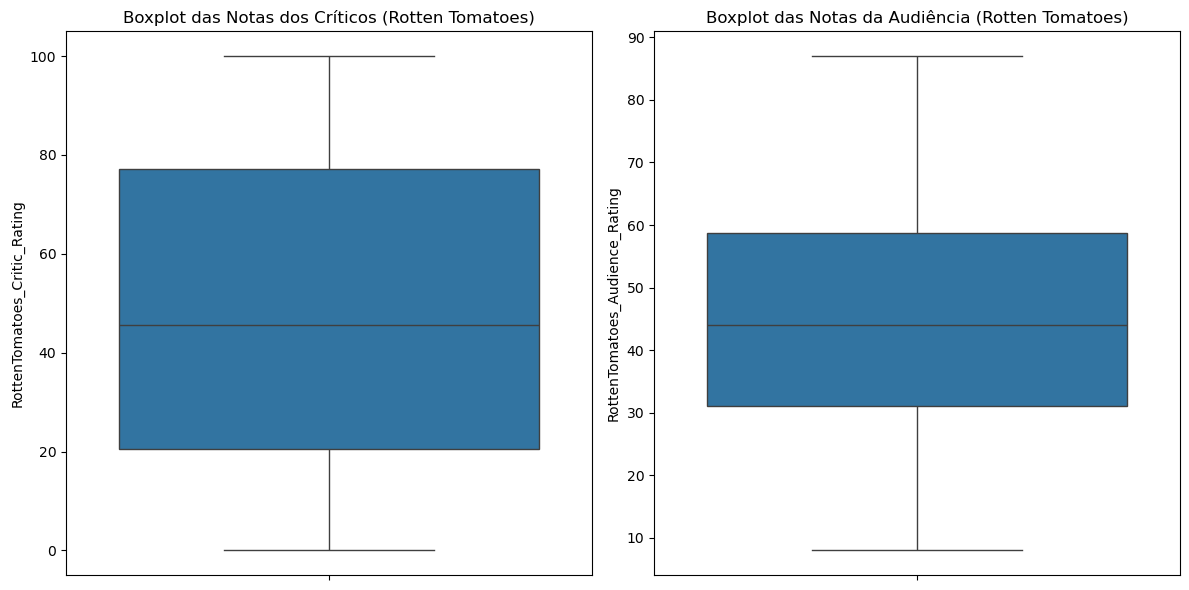

In [56]:
# Função para identificar outliers usando IQR
def detect_outliers_iqr(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data < lower_bound) | (data > upper_bound)]

# Verificar se as colunas estão no DataFrame
if 'RottenTomatoes_Critic_Rating' in comparison_df.columns and 'RottenTomatoes_Audience_Rating' in comparison_df.columns:
    # Identificar outliers nas notas dos críticos
    critics_outliers = detect_outliers_iqr(comparison_df['RottenTomatoes_Critic_Rating'])
    print(f"Outliers nas Notas dos Críticos: {critics_outliers}")

    # Identificar outliers nas notas da audiência
    audience_outliers = detect_outliers_iqr(comparison_df['RottenTomatoes_Audience_Rating'])
    print(f"Outliers nas Notas da Audiência: {audience_outliers}")

    # Visualizar os outliers usando boxplot
    plt.figure(figsize=(12, 6))
    
    # Boxplot para notas dos críticos
    plt.subplot(1, 2, 1)
    sns.boxplot(y=comparison_df['RottenTomatoes_Critic_Rating'])
    plt.title('Boxplot das Notas dos Críticos (Rotten Tomatoes)')

    # Boxplot para notas da audiência
    plt.subplot(1, 2, 2)
    sns.boxplot(y=comparison_df['RottenTomatoes_Audience_Rating'])
    plt.title('Boxplot das Notas da Audiência (Rotten Tomatoes)')

    plt.tight_layout()
    plt.show()
else:
    print("As colunas de notas dos críticos e/ou audiência não estão disponíveis no DataFrame 'comparison_df'. Verifique os dados.")